# Análise de Mídias Sociais: Twitter

Para autenticar no twitter, temos que criar uma conta e accessar: <br />
http://twitter.com/apps/ <br />
Gerar as chaves de autenticação, ex:<br />
CONSUMER_KEY = 'Riew8e4LKVoEJ51HbeOm6wsYA' <br />
CONSUMER_SECRET = '3pPE1z3kTJGQiY93yCqgLUTURJO2wOcoQCcMbyMbCj4Gm9Hc6N' <br />
OAUTH_TOKEN = '2904474861-kdalTd2NVus3q0PdvAiD3gB2IlF9IFZzao01ol7' <br />
OAUTH_TOKEN_SECRET = '2yHMlMAEUZflpw5swYaLA8EjFyPyPJWnJT84VJoAHDKCU' <br />

## Modulo para autenticação no twitter

In [ ]:
#!pip install twitter

In [1]:
import twitter

def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    CONSUMER_KEY = 'ZQ9kvzCwoOhkP3db5nZCuqqME'
    CONSUMER_SECRET = 'z3Zvk1GXmvIajH7XqvCYwQ4fo239C70C2FhHDzSF1STMhXFlQN'
    OAUTH_TOKEN = '2904474861-VhrCBeIPSiN4zhEX5WiqBiMIqjL6Ud87kqMqpEF'
    OAUTH_TOKEN_SECRET = 'c3myFUsxGKeS2QJTWrNQpFYkEg6iDpsBROSSczkJEQY6U'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print (twitter_api)

## Módulo para buscar tweets, dado uma palavra

In [2]:
def twitter_search(twitter_api, q, max_results=1000, **kw):  #max_results=200

    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets and 
    # https://dev.twitter.com/docs/using-search for details on advanced 
    # search criteria that may be useful for keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    search_results = twitter_api.search.tweets(q=q, count=1000, **kw)   # count=100
    
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://dev.twitter.com/docs/rate-limiting/1.1/limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

## Salvando/Recuperando no MongoDB

In [3]:
import json
import pymongo # pip install pymongo


def save_to_mongo(data, mongo_db, mongo_db_coll, **mongo_conn_kw):
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    
    # Reference a particular collection in the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the IDs
    
    return coll.insert_many(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, **mongo_conn_kw):
    
    # Optionally, use criteria and projection to limit the data that is 
    # returned as documented in 
    # http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Consider leveraging MongoDB's aggregations framework for more 
    # sophisticated queries.
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]

## Capturando tweets

In [11]:
result = twitter_search(twitter_api, q, max_results=1000)
type(results)

list

In [13]:
q = 'petrobras'

twitter_api = oauth_login()
results = []
for i in range(10):
    result = twitter_search(twitter_api, q, max_results=1000)
    print ('capturando ', len(result),' tweets...')
    results.extend(result) # junçao de 2 lstas
    #results += result
#print(type(result))
#print(type(results))
print("Numero de tweets capturados: ", len(results))

#results = twitter_search(twitter_api, q, max_results=1000)
#save_to_mongo(results, 'tweets', q)

capturando  1100  tweets...
capturando  1100  tweets...
capturando  1100  tweets...
capturando  1100  tweets...
capturando  1100  tweets...
capturando  1100  tweets...
capturando  1100  tweets...
capturando  1100  tweets...
capturando  1100  tweets...
capturando  1100  tweets...
Numero de tweets capturados:  11000


In [14]:
results[1]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue May 08 19:49:35 +0000 2018',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [{'display_url': 'acordacidade.com.br/noticias/19378…',
    'expanded_url': 'https://www.acordacidade.com.br/noticias/193784/petrobras-elevara-botijao-de-gas-para-industria-e-comercio-em-71-.html',
    'indices': [67, 90],
    'url': 'https://t.co/OGXbJGTOWL'}],
  'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 993941000790904832,
 'id_str': '993941000790904832',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'pt',
 'metadata': {'iso_language_code': 'pt', 'result_type': 'recent'},
 'place': None,
 'possibly_sensitive': False,
 'retweet_count': 0,
 'retweeted': False,
 'source': '<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>'

In [15]:
results[1]['created_at']

'Tue May 08 19:49:35 +0000 2018'

In [16]:
results[1]['metadata']['iso_language_code']

'pt'

In [18]:
len(results)

11000

## imprimindo tweets

In [19]:
i = 0
for tweet in results:
    print(tweet['place'], tweet['created_at'], ' >> ', tweet['text'] , " >> ", )
    i += 1
    if i > 10:
          break

None Tue May 08 19:50:44 +0000 2018  >>  RT @deltanmd: 51ª fase da Lava Jato investiga pagamento de 200 milhões de reais em propinas, em grande parte para operadores do PMDB. De no…  >> 
None Tue May 08 19:49:35 +0000 2018  >>  Petrobras elevará botijão de gás para indústria e comércio em 7,1% https://t.co/OGXbJGTOWL  >> 
None Tue May 08 19:49:06 +0000 2018  >>  RT @cinefilo_K: “o PT destruiu a PETROBRAS”

baby... o FHC entregou a Petrobras valendo 15 bilhões em 2002 e depois dos governos Lula-Dilma…  >> 
None Tue May 08 19:48:58 +0000 2018  >>  RT @DilmaRousseffV: O PT conseguiu deixar o país  num estado tão deplorável com os assaltos a Petrobras, BNDES, educação pública e mídia, q…  >> 
None Tue May 08 19:48:57 +0000 2018  >>  RT @RHPozzobon: 51a Fase da LJ:
-"Para os ex-funcionários da Petrobras, há provas de repasses de cerca de US$ 25 milhões"
-"Os elementos de…  >> 
None Tue May 08 19:48:39 +0000 2018  >>  Ex-engenheiro da Petrobras é preso no Rio em nova fase da Operação Lava Ja

## Nuvem de Palavras - tweet

### Stopwords

In [20]:
# instalando o módulo de stopwords
#!pip install stop-words

In [21]:
from stop_words import get_stop_words
stop_words_english = get_stop_words('en')
#stop_words
stop_words_portugues = get_stop_words('pt')
#stop_words_portugues
stop_words = stop_words_english + stop_words_portugues
print(stop_words[:10])
print(stop_words[-10:])

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']
['tém', 'tínhamos', 'um', 'uma', 'você', 'vocês', 'vos', 'à', 'às', 'éramos']


In [22]:
#!pip install wordcloud

1133901


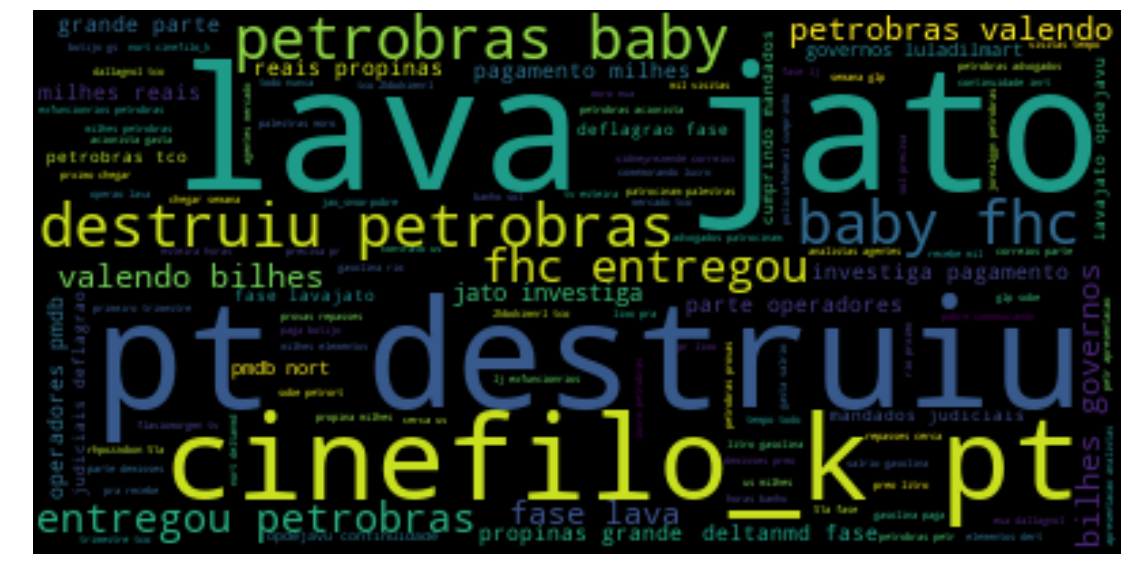

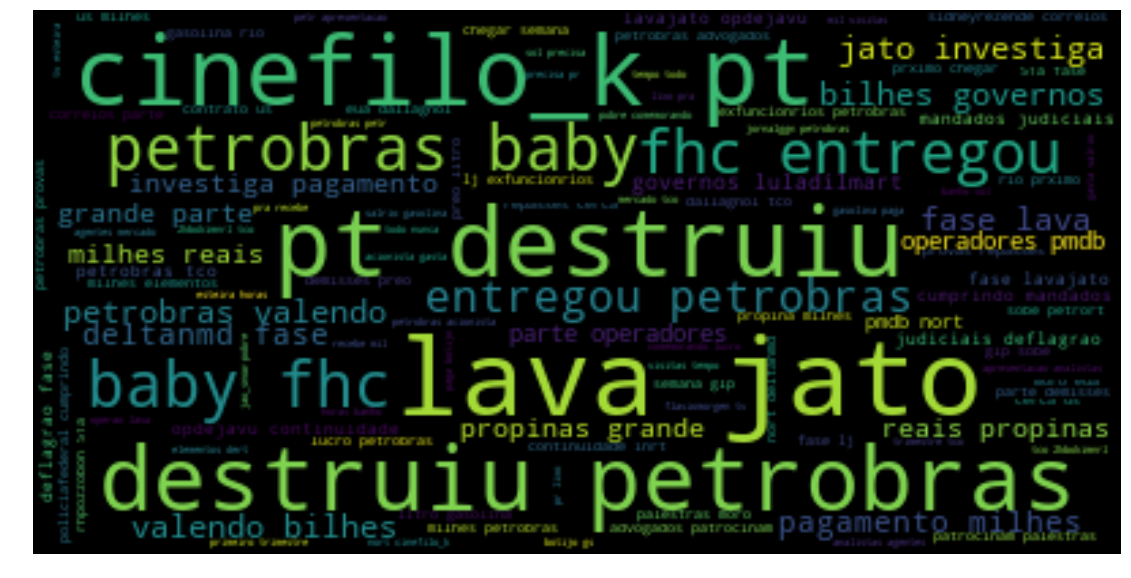

In [24]:
# nuvem de palavras
from wordcloud import WordCloud, STOPWORDS
import re

stext = ""
for tweet in results:
    if 'text' in tweet:
        stext = stext + tweet['text']
stext = stext.lower() # colocar para minúsculas

# retirando pontuações e outros caracteres não relevantes
stext = "".join([i for i in stext if ord(i)<128])
stext = stext.replace("http://","")
stext = stext.replace("https://","")
stext = stext.replace("https","")
stext = stext.replace(",","")
stext = stext.replace(".","")
stext = stext.replace("?","")
stext = stext.replace("!","")
stext = stext.replace("#","")
stext = stext.replace("@","")
stext = stext.replace("'","")
stext = stext.replace("-","")
stext = stext.replace("3","")
stext = stext.replace("&amp;","")
stext = stext.replace("|","")



# retirando as stopwords dos tweets
for word in stop_words:
    my_regex = r"\b(?=\w)" + re.escape(word) + r"\b(?!\w)"
    stext = re.sub(my_regex,"" ,stext)

print(len(stext))


# Generate a word cloud image
wordcloud = WordCloud().generate(stext)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(stext)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Estatistica de contagem de palavras

In [25]:
words = stext.split()

In [26]:
from collections import Counter

c = Counter(words)
#print (c.most_common()[:30])
most_common = c.most_common()[:40]

for i in most_common:
    print (i[0])
#for item in words:  #[words, screen_names, hashtags]:
#    c = Counter(item)
#    print (c.most_common()[:20]) # top 10
#    print 

petrobras
fase
lava
bilhes
milhes
jato
51
pt
200
r$
destruiu
fhc
cinefilo_k:
baby
entregou
valendo
15
2002
governos
parte
investiga
pagamento
reais
operadores
grande
pmdb
deltanmd:
propinas
luladilmart
nort
2
gasolina
petrobrs
lavajato
d
trimestre
lucro
judiciais
us$
cumprindo


In [27]:
for i in range(15):
    print (c.popitem())

('tco/aoxh4ic2tdrt', 1)
('gra', 1)
('falencia', 1)
('levar', 1)
('esforado', 1)
('notcia', 1)
('tima', 1)
('nocenossaum', 4)
('tco/rrvz7ginort', 4)
('feliz', 4)
('petrobra"', 4)
('tco/ipcngjlnrt', 5)
('interessa', 5)
('aliana', 5)
('noprivatizao', 5)


## colocando as palavras e suas frequencias do twitter num dataframe

In [28]:
import pandas as pd
df = pd.DataFrame(([word, freq] for word, freq in most_common), columns=['Word', 'Frequency'])
df[:15]

,Word,Frequency
0,petrobras,7131
1,fase,2521
2,lava,2205
3,bilhes,2184
4,milhes,2174
5,jato,2148
6,51,2118
7,pt,1923
8,200,1863
9,r$,1836


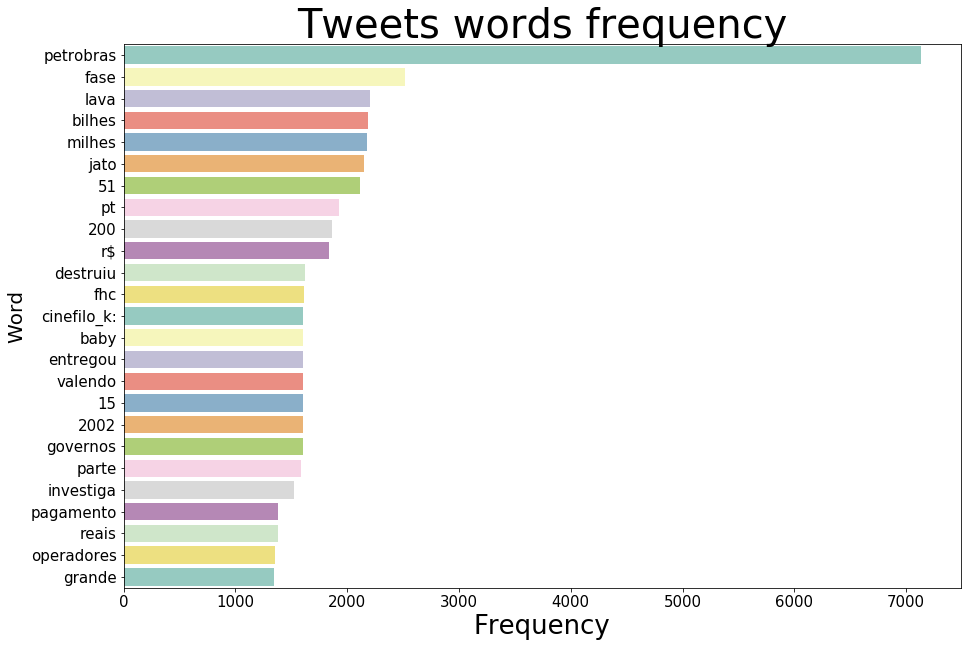

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='Word', x = 'Frequency', data=df2, palette="Set3" )
#sns.despine()
ax.set(xlabel='Tweets words frequency', ylabel='Word')
#ax.set(xticks=range(1, 9), xticklabels=list([10,20,30,40,50,60,70,80,90]))

#ax.set(xticklabels=list(range(0,90,10)))
#plt.figure(figsize=(20,10))

ax.axes.set_title("Tweets words frequency",fontsize=40)
ax.set_xlabel("Frequency",fontsize=26)
ax.set_ylabel("Word",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## achar os países de onde foram gerados os tweets

In [30]:
place = []
for result in results:
    if 'place'in result and result['place']:
        place.append(result['place']['country'])
place = set(place)
print(len(place) )
print(place)

3
{'United States', 'Dominican Republic', 'Brazil'}


In [31]:
# cidades
place = []
for result in results:
    if 'user'  in result:
        place.append(result['user']['location'])
location = set(place)
len(location)

431

In [32]:
for i in range(15):
    print(location.pop())


Curitiba, Brazil
México
Amsterdam
Florianópolis, Brazil
Ceará, Brasil
ÜT: -5.860447,-35.197846
Porto Alegre/RS
São Bernardo do Campo, Brasil
Parintins, Brasil
Catende-PE e Palmares-PE
Jacarepaguá, Rio de Janeiro
Brasil - Sp
Macaé
Ribeira, Salvador


## contar a ocorrencia de cada cidade

In [33]:
from collections import Counter

c = Counter(location)
#print(c)
cidades = c.items()

## colocando as cidades, frequencia num dataframe e salvando no excel

In [34]:
import pandas as pd
df = pd.DataFrame(([cidade, freq] for cidade, freq in cidades), columns=['city', 'frequency'])

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('cidades.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
df[:15]

,city,frequency
0,Santo André - SP,1
1,Mossoró,1
2,"Nova Friburgo, Brasil",1
3,San Juan de la Maguana RD,1
4,Goiania,1
5,"Distrito Capital, Venezuela",1
6,with Hades in the Underworld.,1
7,"Vitória, Brasil",1
8,"ÜT: 10.4813066,-66.7911625",1
9,"Boa Vista, Brasil",1


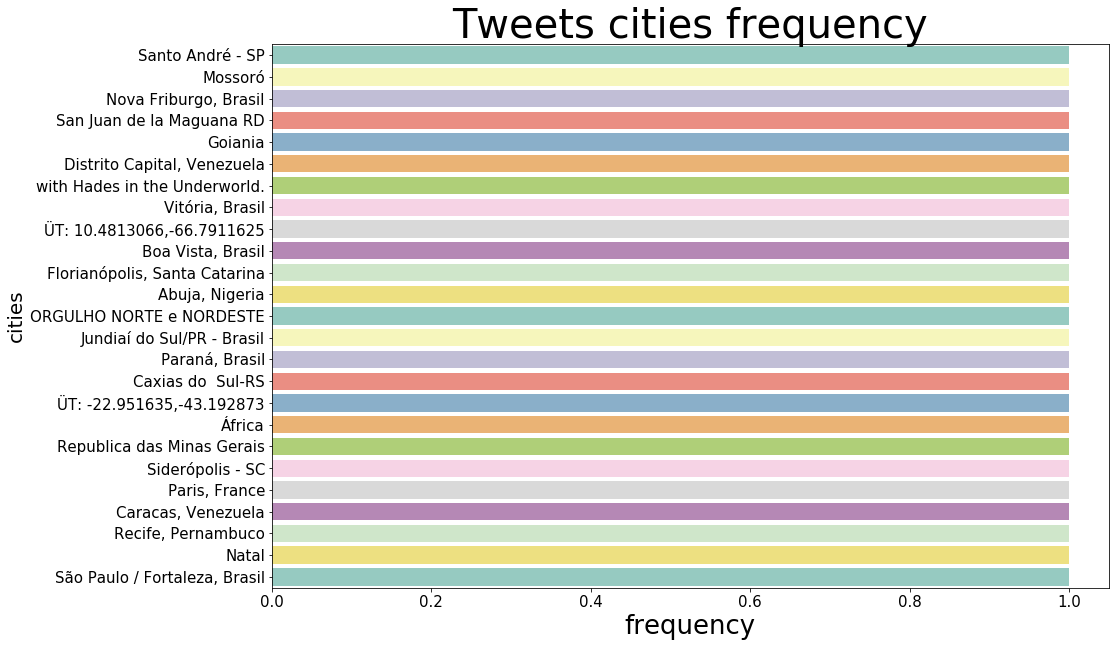

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='city', x = 'frequency', data=df2, palette="Set3" )
ax.set(xlabel='Tweets cities frequency', ylabel='cities')
ax.axes.set_title("Tweets cities frequency",fontsize=40)
ax.set_xlabel("frequency",fontsize=26)
ax.set_ylabel("cities",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## Capturar tweets com coodenadas de lat, long para cidade

In [36]:
def captura_tweets_com_coordenadas(tweets):
    tweets_com_coordenadas = []
    for tweet in tweets:
        if tweet['place'] is not None:
            tweets_com_coordenadas.append(tweet)
    return (tweets_com_coordenadas)

In [37]:
tweets_com_coordenadas = captura_tweets_com_coordenadas(results)
print(len(tweets_com_coordenadas))

115


In [38]:
tweets_com_coordenadas[0]['place']['bounding_box']

{'coordinates': [[[-95.823268, 29.522325],
   [-95.069705, 29.522325],
   [-95.069705, 30.1546646],
   [-95.823268, 30.1546646]]],
 'type': 'Polygon'}

In [39]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates']

[[[-95.823268, 29.522325],
  [-95.069705, 29.522325],
  [-95.069705, 30.1546646],
  [-95.823268, 30.1546646]]]

In [40]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates'][0][0]

[-95.823268, 29.522325]

In [41]:
def captura_coordenadas(tweets):
    coordenadas = []
    for tweet in tweets:
        coord = tweet['place']['bounding_box']['coordinates'][0][0]
        coordenadas.append(coord)
    return coordenadas

In [42]:
tweets_coordenadasXY = captura_coordenadas(tweets_com_coordenadas)
tweets_coordenadasXY[:5]

[[-95.823268, 29.522325],
 [-69.9963185929507, 18.424797835135],
 [-73.991482, -33.7510506],
 [-46.826039, -24.008814],
 [-45.187524, -19.487247]]

In [43]:
len(tweets_com_coordenadas)

115

In [44]:
latitudes_tweets =  [ y for x,y in tweets_coordenadasXY]
longitudes_tweets =  [ x for x,y in tweets_coordenadasXY]

In [45]:
coordenadas_distintas = set(latitudes_tweets)
len(coordenadas_distintas)

11

In [46]:
latitudes_tweets[:5]

[29.522325, 18.424797835135, -33.7510506, -24.008814, -19.487247]

In [47]:
longitudes_tweets[:5]

[-95.823268, -69.9963185929507, -73.991482, -46.826039, -45.187524]

In [48]:
!pwd

/Users/vladimiralencar/Dropbox/BigDataAnalytics/MidiasSociais


# Georeferenciar os tweets no mapa mundi

In [81]:
# !pip install folium

In [108]:
import folium
from folium.utilities import write_png

mapit = folium.Map(location=[30, 0], zoom_start=2)
for coord in tweets_coordenadasXY:
    folium.CircleMarker( location=[ coord[1], coord[0] ], radius=2).add_to( mapit ) 
                    # color='#0080bb', fill_color='#0080bb'

#png_str = write_png(mapit. .data())
#of = open('folium_map.png', 'w')
#of.write(png_str)
#of.close()

folium.Map.save(mapit, "index.html")
#import os
#cmd = 'cutycapt --url=file:///index.html --out=folium_map.png'
#os.system(cmd)

mapit

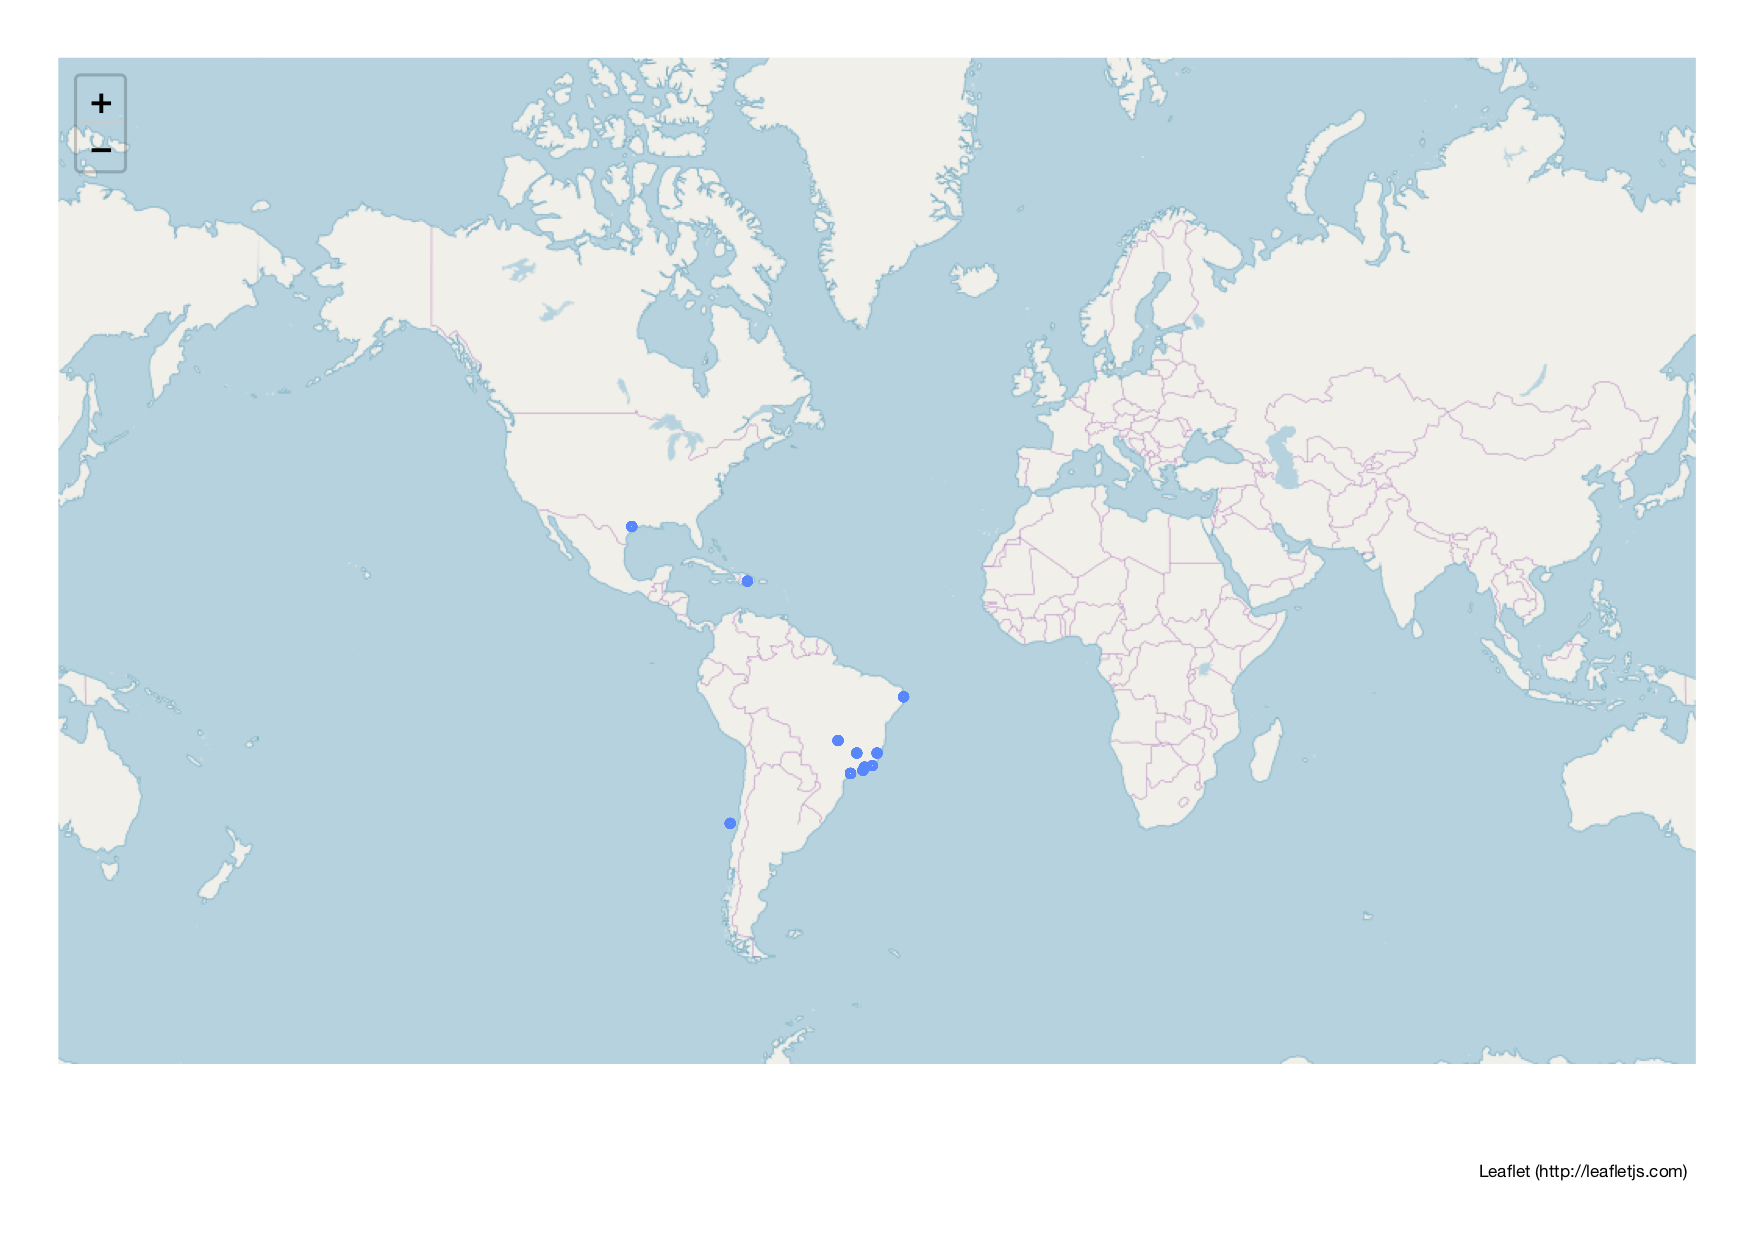

In [93]:
from IPython.display import Image 
Image(filename='index.png')

In [94]:
# !pip install reverse_geocoder
import reverse_geocoder as rg

coordinates = (51.5214588,-0.1729636),(9.936033, 76.259952)
coordinates=(37.38605,-122.08385)
results = rg.search(coordinates) # default mode = 2
print (results)

[OrderedDict([('lat', '37.38605'), ('lon', '-122.08385'), ('name', 'Mountain View'), ('admin1', 'California'), ('admin2', 'Santa Clara County'), ('cc', 'US')])]


In [66]:
import reverse_geocoder as rg

#coordinates = (-23.967967, -47.508358)
#cooordinates = (-8.157554, -35.019805 ), (-8.157554, -34.858893)
cordinates = (-43.4161389,-22.8132778)
cordinates = (-22.8132778, -43.4161389)
results = rg.search(coordinates) # default mode = 2
print (results)

[OrderedDict([('lat', '37.38605'), ('lon', '-122.08385'), ('name', 'Mountain View'), ('admin1', 'California'), ('admin2', 'Santa Clara County'), ('cc', 'US')])]


# twitter trends - assuntos mais comentados do momento

In [67]:
import json
import twitter

def twitter_trends(twitter_api, woe_id):
    # Prefix ID with the underscore for query string parameterization.
    # Without the underscore, the twitter package appends the ID value
    # to the URL itself as a special-case keyword argument.
    return twitter_api.trends.place(_id=woe_id)

# Sample usage

twitter_api = oauth_login()

# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/ for details on
# Yahoo! Where On Earth ID

WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
#print json.dumps(world_trends, indent=1)

US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
#print (json.dumps(us_trends, indent=1))
#us_trends[0]

#for trend in us_trends:
#    print (trend['as_of']['name'])

In [68]:
def find_trends(country_trends):
    trends = country_trends[0]['trends']
    for trend in trends:
        print (trend['name'])

In [69]:
WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
print ("topicos mais comentados: Mundo")
find_trends(world_trends)

topicos mais comentados: Mundo
#Eurovision
T A M A M
Iran
#VHFPSG
#io18
#TeacherAppreciationDay
#SWASOU
Mark Ingram
Mercy
El FMI
#dimartedi
#جده_الان
#AlTurkiParole
#12stig
#WeAreSorrySelena
#TierraDeNadie8
#LOVE_YOURSELF
#GoogleIO
#SonamAnandReception
#ShawnMendesTheTour
#FamaABailarM8
#زواج_الركاض
#BisbalEH
#برجام
#YarınİmzalarPerinçeke
#YoSoyDonJose
#MartinFierro2018
#FirstDates634


In [70]:
US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
print ("topicos mais comentados: USA")
find_trends(us_trends)

topicos mais comentados: USA
Iran
#TeacherAppreciationDay
#io18
#Eurovision
Mark Ingram
West Brom
John Bolton
#ewgc
#HandsOffSNAP
Bill & Ted 3
Swansea
Damascus
Johnny Manziel
Mercy
Anuel
Google Maps
Roberto Osuna
Wayne Rooney
Southampton
Christiane Amanpour
Nick Franklin
Joe Burrow
North Kansas City
Brock Holt
David Marcus
#TravelTuesday
#FavoriteMomMemory
#TBINChat
#repTourGlendale
#ShawnMendesTheTour
#MomQuotes
#WhyImNotBeachBodReady
#WSJFutureFest
#LifeSentence
#ProtectOurCourts
#BloombergEquality
#ThankYouClyburn
#OurHomesOurVoices
#LethalWeapon
#CitrixSynergy
#SDSummit
#BrandMovies
#SunBeltSB
#EndFamilySeparation
#CBCDemandsJustice


In [71]:
BR_WOE_ID = 23424768
br_trends = twitter_trends(twitter_api, BR_WOE_ID)
print ("topicos mais comentados: Brasil")
find_trends(br_trends)

topicos mais comentados: Brasil
#WeAreSorrySelena
#Eurovision
#LOVE_YOURSELF
Joaquim Barbosa
Alexandre de Moraes
#ArenaLoL
#PesadeloMesmoÉ
UMANOVIVENDOADIFERENÇA
Copa da França
Daronco
Swansea
Xuxa
República Democrática
Android P
Mbappé
Mercy
HAPPY BDAY KATNISS
Sons of Anarchy
Pedro Ken
Cate Blanchett
Flamengo x Emelec
Eduardo da Fonte
GEPE
Comissão Especial
Noveletto
Dona Lindu
Detran-MG
Frente Nacional de Prefeitos
Wilton Pereira Sampaio
O Trump
Conmebol
#ShawnMendesTheTour
#TuesdaySdvFcs
#CoraçãoIndomável082
#XTINADEMI_BBMAs
#Celebridade
#FofocalizandoNoSBT
#GoogleIO
#2Toques
#pimentasperguntam
#ESC2018
#VideoShowAoVivo
#repTourGlendale
#AtardeESua
#ChegaDeAgrotóxicos
#loopinfinito
#AsAventurasDePoliana
#VHFPSG
#Cannes2018
#SelecaoSporTV


# Análise de Sentimentos - Tweets

In [ ]:
#!pip install textblob

In [ ]:
#!pip install googletrans

In [95]:
# googletrans token
from googletrans.gtoken import TokenAcquirer
acquirer = TokenAcquirer()
text = 'test'
tk = acquirer.do(text)
tk

'737456.866067'

In [96]:
from googletrans import Translator
translator = Translator()
translator.translate('oi, tudo bem', src='pt').text

'Hello all well'

In [97]:
from textblob import TextBlob as tb #NLP module
import numpy as np #for some calculation. You may want to use your favorite module for this, such as statistics

# polatidade de tweets em ingles e portugues
def polarity_tweets_pais(query):
    from googletrans import Translator
    
    translator = Translator() # google tradutor

    twitter_api = oauth_login()
    numero_iteracoes = 1
    results = []
    for i in range(numero_iteracoes):
        max_results = 500 # 1000
        result = twitter_search(twitter_api, query, max_results=max_results)
        print ('capturando ', len(result),' tweets...')
        #results.append(result)
        results += result

    analysis = None
    pos_polarity = 0
    neutral_polarity = 0
    neg_polarity = 0
    sum_polarity = 0
    print("calculando polaridades...")

    for tweet in results:
        text_tweet = tweet['text']
        
        # retirando caracteres malucos
        text_tweet = "".join([i for i in text_tweet if ord(i)<128])
        
        frase = tb(text_tweet)       
        language = tweet['lang'] #frase.detect_language()
        if language == 'br' or language == 'pt' :
            text_en = translator.translate(text_tweet, src='pt').text  
            analysis = tb(text_en)
        elif language == 'en':   
            analysis = frase
        else:
            analysis = ""
            
        if analysis != "": 
            if (analysis.sentiment.polarity > 0):
                pos_polarity += 1
            elif (analysis.sentiment.polarity <= 0):
                neg_polarity += 1
            sum_polarity += analysis.sentiment.polarity

    return sum_polarity, pos_polarity, neg_polarity, neutral_polarity

In [98]:
q = 'tesla'
q = 'lula'

"""
mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
total = pos_polarity + neg_polarity + neutral_polarity 
print('SENTIMENT AVERAGE: ' , mean_polarity/total)
print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100
"""

"\nmean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)\ntotal = pos_polarity + neg_polarity + neutral_polarity \nprint('SENTIMENT AVERAGE: ' , mean_polarity/total)\nprint('Positive: ', pos_polarity, (pos_polarity/total) * 100)\nprint('Negative: ', neg_polarity, (neg_polarity/total) * 100)\nprint('neutral: ', neutral_polarity, (neutral_polarity/total) * 100\n"

In [99]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'pos', 'negative', 'sentiment_avg'])
queries = [ 'tesla', 'facebook', 'trump', 'china', 'brazil', 'brasil', 'lula', 'sergio moro', 'temer', 'stf', 'stj']

for q in queries:
    mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
    total = pos_polarity + neg_polarity + neutral_polarity 
    print('Query: ', q)
    print('SENTIMENT AVERAGE: ' , mean_polarity/total)
    print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
    print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
    print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100)
    print('----------------------------------------------')
    
    i = len(df)
    df.loc[i] = [q, pos_polarity, neg_polarity, mean_polarity/total]
df

capturando  600  tweets...
calculando polaridades...
Query:  tesla
SENTIMENT AVERAGE:  0.03907420209701576
Positive:  204 38.78326996197718
Negative:  322 61.21673003802282
neutral:  0 0.0
----------------------------------------------
capturando  600  tweets...
calculando polaridades...
Query:  facebook
SENTIMENT AVERAGE:  0.11172463242870838
Positive:  104 54.736842105263165
Negative:  86 45.26315789473684
neutral:  0 0.0
----------------------------------------------
capturando  600  tweets...
calculando polaridades...
Query:  trump
SENTIMENT AVERAGE:  0.06046804201697858
Positive:  209 36.28472222222222
Negative:  367 63.71527777777778
neutral:  0 0.0
----------------------------------------------
capturando  600  tweets...
calculando polaridades...
Query:  china
SENTIMENT AVERAGE:  0.04934084537784086
Positive:  101 22.6457399103139
Negative:  345 77.3542600896861
neutral:  0 0.0
----------------------------------------------
capturando  600  tweets...
calculando polaridades...
Qu

,name,pos,negative,sentiment_avg
0,tesla,204,322,0.039074
1,facebook,104,86,0.111725
2,trump,209,367,0.060468
3,china,101,345,0.049341
4,brazil,290,233,0.117481
5,brasil,173,343,0.073410
6,lula,141,309,0.039492
7,sergio moro,14,180,-0.008039
8,temer,160,328,0.021725
9,stf,137,382,0.027445


In [100]:
df["%pos"] = df.pos / (df.pos + df.negative)
df["%neg"] = df.negative / (df.pos + df.negative)
df["%pos"] = df["%pos"].apply(lambda x: int(round(x,1) * 100))
df["%neg"] = df["%neg"].apply(lambda x: int(round(x,1) * 100))
df.loc[:, ['name', "%pos", "%neg", 'sentiment_avg' ]]

,name,%pos,%neg,sentiment_avg
0,tesla,40,60,0.039074
1,facebook,50,50,0.111725
2,trump,40,60,0.060468
3,china,20,80,0.049341
4,brazil,60,40,0.117481
5,brasil,30,70,0.073410
6,lula,30,70,0.039492
7,sergio moro,10,90,-0.008039
8,temer,30,70,0.021725
9,stf,30,70,0.027445


### gravando os dados do dataframe num arquivo .csv

In [101]:
from datetime import datetime
data_agora = str(datetime.now())
df.to_csv("sentimentos-"+ data_agora +".csv")

In [102]:
df.loc[:, ['name', "%pos", "%neg" ]]

,name,%pos,%neg
0,tesla,40,60
1,facebook,50,50
2,trump,40,60
3,china,20,80
4,brazil,60,40
5,brasil,30,70
6,lula,30,70
7,sergio moro,10,90
8,temer,30,70
9,stf,30,70


### Testando as polaridades

In [103]:
txt = 'good'
analysis = tb(txt)
analysis.sentiment.polarity

0.7

In [104]:
txt = 'bad girl in NY'
analysis = tb(txt)
analysis.sentiment.polarity
analysis.sentiment

Sentiment(polarity=-0.6999999999999998, subjectivity=0.6666666666666666)

In [105]:
txt = 'neutral'
analysis = tb(txt)
analysis.sentiment.polarity

0.0

In [106]:
txt = 'péssimo'
tb_txt = tb(txt)
tb_txt.sentiment.polarity
txt = tb_txt.translate(to='en')
txt.sentiment.polarity

-1.0